In [28]:
from transformers import AutoModelForCausalLM, AutoTokenizer
import torch
from IPython.display import  clear_output
import time

device = 'cuda' if torch.cuda.is_available() else 'cpu'

DEFAULT_MODEL = "meta-llama/Llama-3.2-3B-Instruct"


model = AutoModelForCausalLM.from_pretrained(
    DEFAULT_MODEL,
    torch_dtype=torch.bfloat16,
    use_safetensors=True,
    device_map=device,
)

tokenizer = AutoTokenizer.from_pretrained(DEFAULT_MODEL, use_safetensors=True)
tokenizer.pad_token_id = tokenizer.eos_token_id

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [32]:
conversation = [
    {"role": "system", "content": '''you are a retrival augmented generation chat bot. Here are some text, use this to reply to the user's query: Presidential elections were held in the United States on November 5, 2024.[a] The Republican Party's ticket—Donald Trump, who was the 45th president of the United States from 2017 to 2021, and JD Vance, the junior U.S. senator from Ohio—defeated the Democratic Party's ticket—Kamala Harris, the incumbent vice president, and Tim Walz, the 41st governor of Minnesota.[6][7]

The incumbent president, Joe Biden of the Democratic Party, initially ran for re-election as the party's presumptive nominee,[8] facing little opposition and easily defeating Representative Dean Phillips of Minnesota during the Democratic primaries;[9] however, what was broadly considered a poor debate performance in June 2024 intensified concerns about his age and health, and led to calls within his party for him to leave the race.[10] After initially declining to do so, Biden withdrew on July 21, becoming the first eligible incumbent president to withdraw since Lyndon B. Johnson in 1968.[11] Biden endorsed Harris,[12] who was voted the party's nominee by the delegates on August 5 and became the first nominee who did not participate in the primaries since Hubert Humphrey, also in 1968. Harris selected Walz as her running mate.[13][14] This was the first time since 2000 in which an incumbent vice president ran for president.'''},
    {"role": "user", "content": '''who won 2024 US election'''},
]

prompt = tokenizer.apply_chat_template(conversation, tokenize=False)
inputs = tokenizer(prompt, return_tensors="pt").to(device)
# print(prompt)

with torch.no_grad():
    output = model.generate(
        **inputs,
        do_sample=True,
        max_new_tokens=100
    )

processed_text = tokenizer.decode(output[0], skip_special_tokens=False)

print(processed_text)

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


<|begin_of_text|><|begin_of_text|><|start_header_id|>system<|end_header_id|>

Cutting Knowledge Date: December 2023
Today Date: 10 Mar 2025

you are a retrival augmented generation chat bot. Here are some text, use this to reply to the user's query: Presidential elections were held in the United States on November 5, 2024.[a] The Republican Party's ticket—Donald Trump, who was the 45th president of the United States from 2017 to 2021, and JD Vance, the junior U.S. senator from Ohio—defeated the Democratic Party's ticket—Kamala Harris, the incumbent vice president, and Tim Walz, the 41st governor of Minnesota.[6][7]

The incumbent president, Joe Biden of the Democratic Party, initially ran for re-election as the party's presumptive nominee,[8] facing little opposition and easily defeating Representative Dean Phillips of Minnesota during the Democratic primaries;[9] however, what was broadly considered a poor debate performance in June 2024 intensified concerns about his age and health, 

In [6]:
from sentence_transformers import SentenceTransformer
# 1. Load a pretrained Sentence Transformer model
model = SentenceTransformer("all-MiniLM-L6-v2")

sentences = [
    "The cat sat on the mat.",
    "A black cat is lying on the floor.",
    "I saw a cat playing with a ball of yarn.",
    "My cat loves to nap in the sun.",
    "The cat chased the mouse around the house.",
    "The sky is blue and clear today.",
    "I enjoy reading books in the evening.",
    "Bananas are my favorite fruit.",
    "The train left the station on time.",
    "The car engine roared as it started."
]

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.5k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [23]:
# 2. Calculate embeddings by calling model.encode()
embeddings = model.encode(sentences, convert_to_tensor=True)
print(embeddings.shape)
# [3, 384]
# 3. Calculate the embedding similarities
similarities = model.similarity(embeddings, embeddings)
print(similarities)

torch.Size([10, 384])
tensor([[ 1.0000,  0.6232,  0.5023,  0.4426,  0.3480,  0.0505, -0.0058,  0.0165,
          0.1436,  0.0524],
        [ 0.6232,  1.0000,  0.3732,  0.4673,  0.3104, -0.0131, -0.0237, -0.0363,
          0.1290,  0.0487],
        [ 0.5023,  0.3732,  1.0000,  0.4236,  0.3921,  0.0772,  0.0532,  0.1713,
          0.0617,  0.1955],
        [ 0.4426,  0.4673,  0.4236,  1.0000,  0.2515,  0.2127,  0.2723,  0.1890,
          0.0934,  0.0862],
        [ 0.3480,  0.3104,  0.3921,  0.2515,  1.0000, -0.0040, -0.0042, -0.0452,
          0.0884,  0.2093],
        [ 0.0505, -0.0131,  0.0772,  0.2127, -0.0040,  1.0000,  0.2002,  0.0612,
          0.1230,  0.0687],
        [-0.0058, -0.0237,  0.0532,  0.2723, -0.0042,  0.2002,  1.0000,  0.1972,
          0.0820, -0.0407],
        [ 0.0165, -0.0363,  0.1713,  0.1890, -0.0452,  0.0612,  0.1972,  1.0000,
         -0.0301,  0.0230],
        [ 0.1436,  0.1290,  0.0617,  0.0934,  0.0884,  0.1230,  0.0820, -0.0301,
          1.0000,  0.2197

In [24]:
scores, indices = torch.topk(similarities[0], k=3)

In [26]:
indices

tensor([0, 1, 2], device='cuda:0')

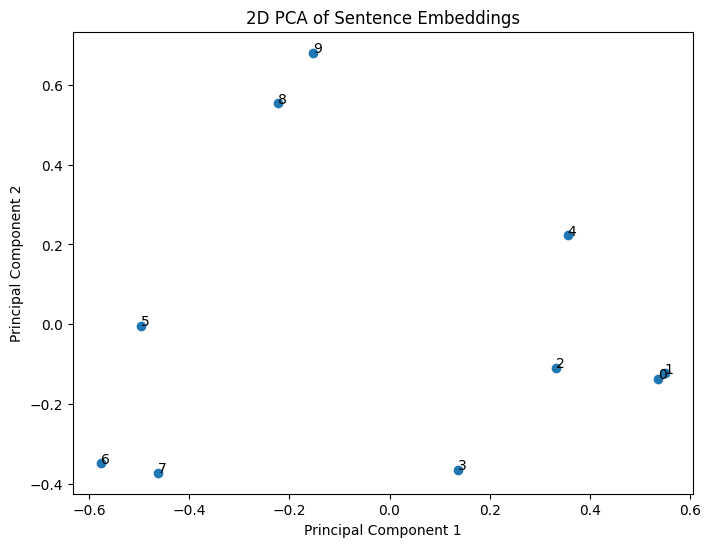

In [9]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sentence_transformers import SentenceTransformer

# 1. Load a pretrained Sentence Transformer model
model = SentenceTransformer("all-MiniLM-L6-v2")

# 2. Define the sentences
sentences = [
    "The cat sat on the mat.",
    "A black cat is lying on the floor.",
    "I saw a cat playing with a ball of yarn.",
    "My cat loves to nap in the sun.",
    "The cat chased the mouse around the house.",
    "The sky is blue and clear today.",
    "I enjoy reading books in the evening.",
    "Bananas are my favorite fruit.",
    "The train left the station on time.",
    "The car engine roared as it started."
]

# 3. Encode the sentences to embeddings
embeddings = model.encode(sentences)

# 4. Reduce the dimensionality to 2D using PCA
pca = PCA(n_components=2)
reduced_embeddings = pca.fit_transform(embeddings)

# 5. Plot the reduced embeddings with sentence indices
plt.figure(figsize=(8, 6))
plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1])

# Annotate each point with the sentence index
for i, sentence in enumerate(sentences):
    plt.annotate(i, (reduced_embeddings[i, 0], reduced_embeddings[i, 1]))

plt.title("2D PCA of Sentence Embeddings")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.show()


In [12]:
model.similarity_fn_name

'cosine'